## Домашнее задание №1

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [ ]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output

%matplotlib inline
device = 'cuda'
torch.cuda.is_available()

True

### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [ ]:
x = torch.rand(7, 9)
y = torch.rand(9, 15)

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`, для создания третьего тензора предлагается использовать `torch.empty`:

In [ ]:
z = torch.empty(7, 15)
z.copy_(x @ y)

tensor([[2.5149, 2.5577, 3.0806, 1.6353, 2.4855, 2.3407, 3.1559, 3.2030, 2.0476,
         2.5601, 2.7792, 2.0637, 2.0056, 3.5118, 2.6796],
        [2.5526, 2.6837, 3.2322, 2.0448, 1.8596, 3.1315, 2.8420, 3.0832, 2.2200,
         2.8804, 2.3497, 2.2634, 2.6523, 3.2870, 3.5056],
        [1.8398, 2.4109, 2.4203, 1.4363, 2.3495, 2.1486, 2.5495, 2.6822, 2.1093,
         2.3080, 2.0583, 2.3647, 1.5728, 2.9140, 2.1814],
        [2.4333, 2.9815, 2.8268, 1.5822, 2.4949, 2.3276, 3.4288, 3.2724, 2.2937,
         2.8107, 2.5462, 2.3160, 2.2193, 3.3928, 2.4914],
        [2.0515, 2.1422, 2.2163, 1.0599, 1.7700, 1.9200, 2.7918, 2.4022, 1.7416,
         2.5537, 2.2661, 1.5197, 1.8190, 2.4285, 2.1843],
        [2.3114, 2.4484, 2.7292, 1.9418, 1.9112, 2.4997, 2.5107, 3.1302, 1.7751,
         2.2277, 1.9045, 2.0167, 2.1869, 3.2394, 2.7879],
        [3.1644, 3.1568, 3.9512, 2.3461, 2.1302, 3.7002, 2.8079, 3.5596, 2.2456,
         2.8549, 1.9951, 2.6319, 2.8261, 3.4821, 3.0880]])

**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [ ]:
def relu_forward(x):
  return np.maximum(x, 0)

assert torch.all(F.relu(x) == relu_forward(x))

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [ ]:
def elu_unv(x):
  if x > 0: 
    return max(x, 0)
  else:
    a = 1
    return a * (math.exp(x) - 1)

In [ ]:
def elu_forward(x):
  shape = x.shape
  x = np.array(torch.reshape(x, [-1]))
  elu_v = np.vectorize(elu_unv)
  ret = elu_v(x)
  ret = np.array(ret, dtype=x.dtype)
  return torch.tensor(ret.reshape(shape))

assert torch.allclose(
    F.elu(x),
    elu_forward(x), 
    1e-4
)

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [ ]:
def lrelu_unv(x, alpha):
  if x > 0: 
    return max(x, 0)
  else:
    return alpha * x

In [ ]:
def lrelu_forward(x, alpha):
  shape = x.shape
  x = np.array(torch.reshape(x, [-1]))
  lrelu_v = np.vectorize(lrelu_unv)
  ret = lrelu_v(x, alpha)
  ret = np.array(ret, dtype=x.dtype)
  return torch.tensor(ret.reshape(shape))


assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [ ]:
def mish_unv(x):
  return x * math.tanh(math.log(1+math.exp(x)))

In [ ]:
def mish(x):
  shape = x.shape
  x = np.array(torch.tensor(torch.reshape(x, [-1]), dtype=x.dtype))
  mish_v = np.vectorize(mish_unv)
  ret = mish_v(x)
  ret = np.array(ret, dtype=x.dtype)
  return torch.tensor(ret.reshape(shape))

In [ ]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [ ]:
def swish_unv(x):
  return x * 1 / (1 + math.exp(-x))

In [ ]:
def swish(x):
  shape = x.shape
  x = np.array(torch.reshape(x, [-1]))
  swish_v = np.vectorize(swish_unv)
  ret = swish_v(x)
  ret = np.array(ret, dtype=x.dtype)
  return torch.tensor(ret.reshape(shape))

In [ ]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Пишем Adam и применяем его к логистической регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [ ]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [ ]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)
        self.t = 0

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']

        if 'm' not in group:
          group['m'] = []
        for param in group['params']:
          group['m'].append(torch.zeros_like(param))
            
        if 'v' not in group:
          group['v'] = []
        for param in group['params']:
          group['v'].append(torch.zeros_like(param))

        for param, m, v in filter(lambda x: x[0].grad is not None, zip(group['params'], group['m'], group['v'])):
            self._init_adam_buffer(param)
            d_param = param.grad
            buffer = self._get_adam_buffer(param)
            buffer.add_(d_param ** 2)
            self.t += 1
            
            m = beta_1 * m + (1 - beta_1) * d_param
            v = beta_2 * v + (1 - beta_2) * np.power(d_param, 2)
            m_h = m / (1 - np.power(beta_1, self.t))
            v_h = v / (1 - np.power(beta_2, self.t))
            d_param /= torch.sqrt(v_h + eps)
            param.add_(m_h, alpha=-lr)

    def _get_adam_buffer(self, param):
        """
        Get accumulated gradients for Adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.

        Returns
        -------
        Accumulated Adam gradients for parameter.
        """
        param_state = self.state[param]
        return param_state['adam_buffer']

    def _init_adam_buffer(self, param):
        """
        Initialize accumulated gradeints for adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for adam.
        """
        param_state = self.state[param]
        if 'adam_buffer' not in param_state:
            param_state['adam_buffer'] = torch.zeros_like(param)

In [ ]:
# check it out

from sklearn.datasets import make_regression


def seed_everything(seed: int):
    # Зафиксировать seed.
    # Это понадобится, чтобы убедиться
    # в правильности работы нашего Optimizer
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


# make_regression возвращает 2 переменные: данные и таргет для них
# так как они возвращаётся как np.array,
# вызовем для каждого из них команду torch.from_numpy
X, y = map(
    lambda x: torch.from_numpy(x).float(),
    make_regression(n_samples=200, n_features=2)
)


def get_model():
    # Таким образом, мы при каждом вызове будем получить
    # модель с одной и той же инициализацией весов
    seed_everything(13)
    return torch.nn.Sequential(
        torch.nn.Linear(2, 10),
        torch.nn.Linear(10, 1)
    )

def check_optimizer(model, optim, num_iter):
    loss = torch.nn.MSELoss()
    for i in range(num_iter):
        output = loss(model(X), y.unsqueeze(-1))
        output.backward()
        optim.step()
        optim.zero_grad()
        if i % 100 == 0:
            print(f'Iteration {i} loss:', output.item())


In [ ]:
model = get_model()
optim = Adam(model.parameters(), lr=0.001)
check_optimizer(model, optim, num_iter=1000)

Iteration 0 loss: 3175.277587890625
Iteration 100 loss: 2744.19091796875
Iteration 200 loss: 1065.5157470703125
Iteration 300 loss: 71.61048126220703
Iteration 400 loss: 4.205193519592285
Iteration 500 loss: 0.3999098241329193
Iteration 600 loss: 0.04185725376009941
Iteration 700 loss: 0.004416357725858688
Iteration 800 loss: 0.0004659622209146619
Iteration 900 loss: 4.91853388666641e-05


In [ ]:
model = get_model()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
check_optimizer(model, optim, num_iter=1000)

Iteration 0 loss: 3175.277587890625
Iteration 100 loss: 3111.456298828125
Iteration 200 loss: 3005.513671875
Iteration 300 loss: 2837.082275390625
Iteration 400 loss: 2608.185791015625
Iteration 500 loss: 2330.712158203125
Iteration 600 loss: 2022.9498291015625
Iteration 700 loss: 1703.9083251953125
Iteration 800 loss: 1390.928955078125
Iteration 900 loss: 1098.656982421875


**Task**: Создайте параметры для обучения логистической регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

In [ ]:
def xavier(n_l, n_r):
  return torch.Tensor(n_l*n_l, 1).uniform_(-1, 1) * math.sqrt(6/(n_l + n_r))


n_in = 28*28 # size of images in Fashion-MNIST
n_out = 10 # number of classes in Fashion-MNIST
weights = xavier(n_in, n_out)
intercept = xavier(n_in, n_out)

In [ ]:
optimizer = Adam([weights, intercept])
loss = nn.CrossEntropyLoss()

Загрузим данные и создадим даталоадеры:

In [ ]:
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = DataLoader(
    fashion_mnist_train, batch_size=128, shuffle=True, num_workers=2
)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = DataLoader(
    fashion_mnist_eval, batch_size=128, num_workers=2
)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Напишите функцию для тренировки логистической регрессии, она должна: 
    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [ ]:
def train_logistic_regression(weights, bias, batch, loss, optimizer):
    

SyntaxError: ignored

In [ ]:
for epoch in range(1, 100):
    for batch in train_dataloader:
        metrics = train_logistic_regression(weights, bias, batch, loss, optimizer)

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

1) Несмещенная оценка получается из того, что все адаптивные методы оптимизации в своей основе приближают второй момент, то есть в методе приближается квадрат градиента математическим ожиданием от квадрата градиента, поэтому оценка получается несмещенная.

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [ ]:
# вывод графиков зависимостей loss и accuracy от итерации

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [ ]:
def train_model(model, dataloader, optimizer):
    criterion = nn.CrossEntropyLoss()
    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []
    EPOCHS = 10 
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.
        train_size = 0
        train_acc = 0.
        for batch in dataloader[0]:
            imgs, labels = batch
            imgs = imgs.cpu()
            labels = labels.cpu()

            optimizer.zero_grad()
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))

            _, pred_classes = torch.max(y_pred, 1)
            train_acc += (pred_classes == labels).sum().item()
            train_acc_log.append(np.mean((pred_classes == labels).cpu().numpy()))


        val_loss = 0.
        val_size = 0
        val_acc = 0.
        model.eval()
        
        with torch.no_grad():
            for batch in dataloader[1]:
                imgs, labels = batch
                imgs = imgs.cpu()
                labels = labels.cpu()
                pred = model(imgs)
                loss = criterion(pred, labels)
                val_loss += loss.item()
                val_size += pred.size(0)

                _, pred_classes = torch.max(pred, 1)
                val_acc += (pred_classes == labels).sum().item()
        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_acc / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        plot_history(train_acc_log, val_acc_log, 'accuracy')

        print('Train loss:', train_loss / train_size)
        print('Train acc:', train_acc / train_size)
        print('Val loss:', val_loss / val_size)
        print('Val acc:', val_acc / val_size) 

In [ ]:
# fully - connected NN
class FirstModel(nn.Module):
    def __init__(self):
        super(FirstModel, self).__init__()
        self.fc1 = nn.Linear(28*28*1, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax()

        
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x
        

"\nclass FirstSimpleNet(torch.nn.Module):\n    def __init__(self, encoder):\n        super().__init__()\n        self._encoder = encoder\n        self._accuracy = Accuracy()\n\n    def forward(self, images, target=None):\n        # images ~ (batch size, num channels, height, width)\n        # target ~ (batch size)\n        # output ~ (batch size, num classes)\n        output = self._encoder(images)\n        output_dict = {'logits': output, 'probs': torch.softmax(output, dim=-1)}\n        output_dict['preds'] = torch.argmax(output_dict['probs'], dim=-1)\n        if target is not None:\n            log_softmax = torch.log_softmax(output, dim=-1)\n            output_dict['loss'] = F.nll_loss(log_softmax, target)\n            self._accuracy(\n                output_dict['preds'].cpu(),\n                target.cpu()\n            )\n        return output_dict\n\n    def decode(self, output_dict):\n        # output_dict ~ dict with torch.Tensors (output_dict from forward)\n        return [idx

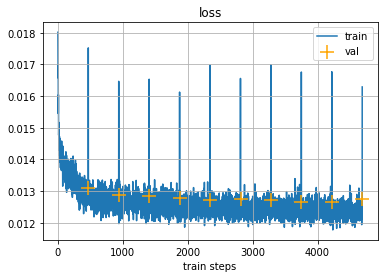

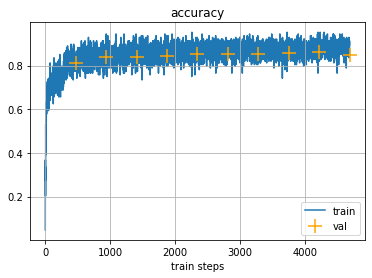

Train loss: 0.012374449916680654
Train acc: 0.8808166666666667
Val loss: 0.012745319592952728
Val acc: 0.8487


In [ ]:
# model 1, optimizer = RMSprop
model = FirstModel()
use_gpu = torch.cuda.is_available()
if use_gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
dataloader = (train_dataloader, eval_dataloader)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
train_model(model, dataloader, optimizer)

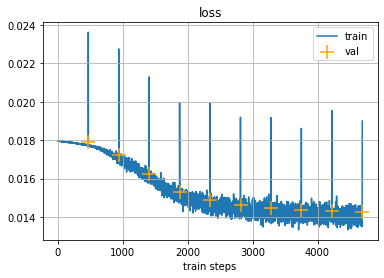

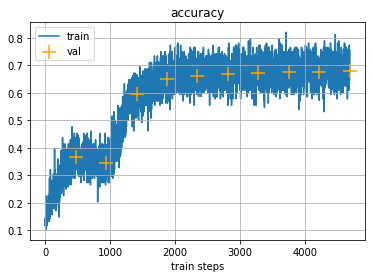

Train loss: 0.01407846040527026
Train acc: 0.6856166666666667
Val loss: 0.014237278044223785
Val acc: 0.6782


In [ ]:
# model 1, optimizer = SGD with momentum
model = FirstModel()
use_gpu = torch.cuda.is_available()
if use_gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
dataloader = (train_dataloader, eval_dataloader)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_model(model, dataloader, optimizer)

In [ ]:
# VGG - like NN
second_model = nn.Sequential(
    nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)),
    nn.Dropout(0.5),
    nn.Flatten(),
    nn.Linear(64*14*14, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax()
)

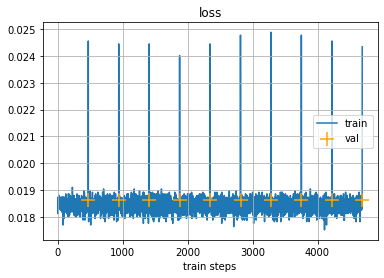

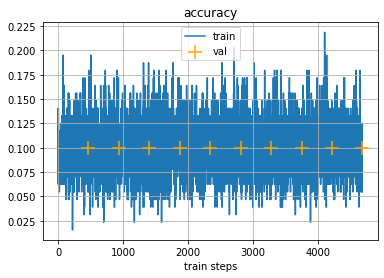

Train loss: 0.018456225248177846
Train acc: 0.1
Val loss: 0.01864543571472168
Val acc: 0.1


In [ ]:
# model 2, optimizer = RMSprop
model = second_model
use_gpu = torch.cuda.is_available()
if use_gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
dataloader = (train_dataloader, eval_dataloader)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.1)
train_model(model, dataloader, optimizer)

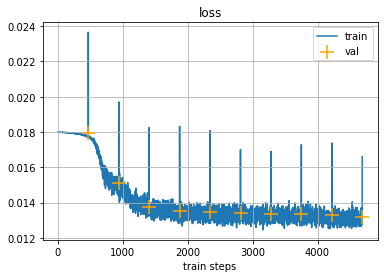

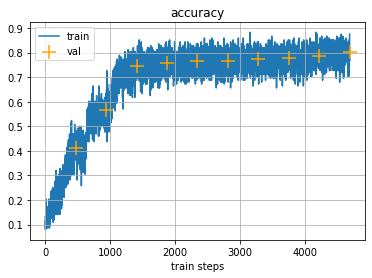

Train loss: 0.01309891125758489
Train acc: 0.7931
Val loss: 0.01316530624628067
Val acc: 0.8004


In [ ]:
# model 2, optimizer = SGD with momentum
model = second_model
use_gpu = torch.cuda.is_available()
if use_gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
dataloader = (train_dataloader, eval_dataloader)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_model(model, dataloader, optimizer)

In [ ]:
# ResNet - like NN
class ThirdModel(nn.Module):
  def __init__(self):
        super(ThirdModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128*3*3, 512)
        self.fc2 = nn.Linear(512, 10)
        
  def forward(self, x):
        x = F.max_pool2d(self.relu(self.conv1(x)), 2)
        x = F.max_pool2d(self.relu(self.conv2(x)), 2)
        x1 = torch.empty(x.shape)
        x1.copy_(x)
        x = self.conv3(x) 
        x1 = F.pad(x1, (0, 0, 0, 0, 32, 32, 0, 0), "constant", 0) # x и x1 должны быть одинаковой размерности
        x = F.max_pool2d(self.relu(x + x1), 2)
        x = x.view(-1, 128*3*3)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


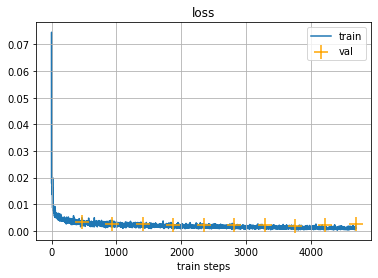

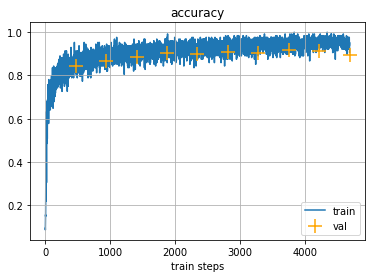

Train loss: 0.0009747702651967605
Train acc: 0.9534666666666667
Val loss: 0.0025202620163559913
Val acc: 0.8946


In [ ]:
# model 3, optimizer = RMSprop
model = ThirdModel()
use_gpu = torch.cuda.is_available()
if use_gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
dataloader = (train_dataloader, eval_dataloader)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
train_model(model, dataloader, optimizer)

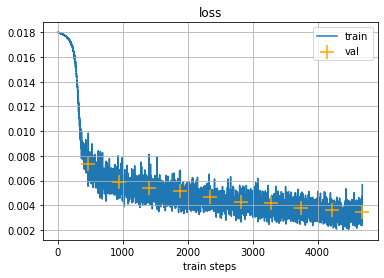

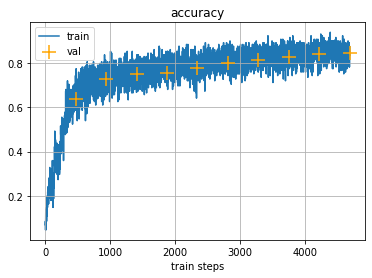

Train loss: 0.003371498939394951
Train acc: 0.8452
Val loss: 0.003439140675961971
Val acc: 0.8453


In [ ]:
# model 3, optimizer = SGD with momentum
model = ThirdModel()
use_gpu = torch.cuda.is_available()
if use_gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
dataloader = (train_dataloader, eval_dataloader)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_model(model, dataloader, optimizer)

In [ ]:
# train and visualize and write summary down there

Наилучший результат показала модель 3 (ResNet-like) с RMSprop оптимизатором (accuracy = 89%, loss = 0.2%). \\
Второй результат также у третьей модели с оптимизатором SGD with momentum и  с accuracy = 84%, loss = 0.3% \\
Такие результаты могли получиться из - за особеннности архитектуры ResNet - учитывая выход не только последнего слоя, но и предпоследнего, удается избежать переобучения (даже при гораздо большем числе слоев, чем в модели 3). Поэтому ResNet - подобная модель обучается лучше.